<a href="https://colab.research.google.com/github/Steven-A3/DeepLearningZeroToAllColab/blob/master/Kaggle_practice_Household_Electric_Power_Consumptionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle - [Household Electric Power Consumption](https://www.kaggle.com/uciml/electric-power-consumption-data-set)

![alt text](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FPupwd%2FbtqBOszdwFh%2FKQDcX0hJ1YLy1CckkjvBlK%2Fimg.png)

- **`Data description`**: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 62kB/s 
     |████████████████████████████████| 3.8MB 27.9MB/s 
     |████████████████████████████████| 450kB 42.1MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

## 환경설정

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
print("Tensorflow version:", tf.__version__)
tf.random.set_seed(777)

Tensorflow version: 2.0.0


## 데이터

- 판다스의 **`read_csv()`** 함수를 통해 데이터를 load
    - **`sep`**: 데이터가 세미콜론(;)으로 나누어져 있기 때문에 sep(erated) 매개변수를 세미콜론(;)으로 지정
    
- **`head()`** 함수를 통해 데이터 확인

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/household_power_consumption.txt", sep=";")
df.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0


- 데이터프레임의 **`shape`** 속성을 통해서 크기 확인
    - 9개의 변수를 가진 2,075,259건의 데이터

In [6]:
df.shape

(2075259, 9)

- **`isnull()`** 함수를 통해 결측치 확인

In [7]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

- 데이터프레임의 **`loc(ation)`** 속성을 통해 결측치 행 확인
    - **`NaN`** 이외에도 **`"?"`**
    - [데이터프레임 인덱싱 참고자료](https://datascienceschool.net/view-notebook/704731b41f794b8ea00768f5b0904512/)

In [8]:
df.loc[df["Sub_metering_3"].isnull(), ].head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN


- **`info()`** 함수를 사용하여 데이터프레임 구조 확인
    - **`"?"`** 때문에 몇몇 변수가 범주형 변수(object)로 저장되어 있음

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


### [결측치 처리](https://datascienceschool.net/view-notebook/d96dcbf7f8ac4ee4bf3875b66b2da654/) - 평균값(Mean imputation)

- **`replace()`** 함수를 사용하여 **`"?"`**를 NaN으로 변환


In [0]:
df.replace('?', np.nan, inplace=True)

In [11]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
df.loc[df["Sub_metering_3"].isnull(), ].head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,21/12/2006,11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- **`describe()`** 함수는 데이터프레임 각 변수의 통계량을 출력

In [13]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


- **`columns`** 속성은 데이터프레임의 열 이름을 리스트로 출력

In [14]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

- 반복문과 **`astype()`** 함수를 사용하여 자료형을 변환

In [0]:
for i in range(2, len(df.columns)):
    column = df.columns[i]
    df[column] = df[column].astype("float64")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [17]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [0]:
for i in range(2, len(df.columns)):
    column = df.columns[i]
    df.loc[df[column].isnull()==True, column] = np.mean(df[column])

In [20]:
df.loc[6839, ]

Date                     21/12/2006
Time                       11:23:00
Global_active_power         1.09162
Global_reactive_power      0.123714
Voltage                      240.84
Global_intensity            4.62776
Sub_metering_1              1.12192
Sub_metering_2              1.29852
Sub_metering_3              6.45845
Name: 6839, dtype: object

### [인덱스](https://datascienceschool.net/view-notebook/a49bde24674a46699639c1fa9bb7e213/) 만들기

In [21]:
df.head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0


- 데이터프레임의 열끼리 연산 가능

In [22]:
df["dt"] = df["Date"] + " " + df["Time"]
df.head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,dt
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16/12/2006 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16/12/2006 17:25:00


- **`to_datetime()`** 함수를 사용하여 문자열 변수를 datetime 형식으로 변환

In [23]:
idx = pd.to_datetime(df["dt"])
idx

0         2006-12-16 17:24:00
1         2006-12-16 17:25:00
2         2006-12-16 17:26:00
3         2006-12-16 17:27:00
4         2006-12-16 17:28:00
                  ...        
2075254   2010-11-26 20:58:00
2075255   2010-11-26 20:59:00
2075256   2010-11-26 21:00:00
2075257   2010-11-26 21:01:00
2075258   2010-11-26 21:02:00
Name: dt, Length: 2075259, dtype: datetime64[ns]

- **`set_index()`** 함수를 이용하여 **`idx`** 변수를 데이터프레임의 인덱스로 지정

In [24]:
df = df.set_index(idx)
df.head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,dt
dt,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16/12/2006 17:24:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16/12/2006 17:25:00


- **`drop()`** 함수를 이용하여 **`Date, Time, dt`** 변수를 삭제

In [25]:
df.drop(["Date", "Time", "dt"], axis=1, inplace=True)
df.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0


- **`resample`** 함수를 이용하여 데이터프레임을 시간별 평균값으로 변환

In [26]:
df_resample = df.resample("h").mean()
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [27]:
df_resample2 = df.resample("W").mean()
df_resample2.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-17,2.505248,0.142118,239.258088,10.664161,1.107298,2.577887,9.949346
2006-12-24,1.734059,0.116708,241.369629,7.341434,1.110342,2.118412,7.684516
2006-12-31,1.958204,0.144105,241.910007,8.237327,1.412623,2.245099,6.671619
2007-01-07,1.152164,0.109719,238.848573,4.885499,1.068861,0.860149,6.093299
2007-01-14,1.421880,0.146196,239.000173,6.065497,2.435584,1.493608,6.924711


## 시각화(Visualization)

In [28]:
!pip install plotly

In [0]:
import plotly.graph_objects as go

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=df_resample2.index,                  # x값 지정
                y=df_resample2["Global_active_power"], # y값 지정
                name="Global active power",            # 그래프 이름 지정
                line_color="steelblue",                # 색깔 지정
                opacity=0.9))                          # 투명도 지정

fig.update_layout(xaxis_range=["2006-12-16", "2010-11-26"], # x축 범위 지정 
                  title_text="Global active power")         # 그래프 제목 지정 
fig.show()

- A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=df_resample2.index,                 # x값 지정
                y=df_resample2["Sub_metering_1"],     # y값 지정
                name="Sub_metering_1",                # 그래프 이름 지정
                line_color="steelblue",               # 색깔 지정
                opacity=0.9))                         # 투명도 지정

fig.add_trace(go.Scatter(
                x=df_resample2.index,                 # x값 지정
                y=df_resample2["Sub_metering_2"],     # y값 지정
                name="Sub_metering_2",                # 그래프 이름 지정
                line_color="red",                     # 색깔 지정
                opacity=0.9))                         # 투명도 지정

fig.add_trace(go.Scatter(
                x=df_resample2.index,                 # x값 지정
                y=df_resample2["Sub_metering_3"],     # y값 지정
                name="Sub_metering_3",                # 그래프 이름 지정
                line_color="green",                   # 색깔 지정
                opacity=0.9))                         # 투명도 지정


fig.update_layout(xaxis_range=["2006-12-16", "2010-11-26"], # x축 범위 지정 
                  title_text="Sub metering")                # 그래프 제목 지정 
fig.show()

## 모델링
### 훈련 세트(train) / 시험 세트(test) 나누기

- 데이터프레임의 **`values`** 속성은 데이터프레임의 값들을 넘파이 배열로 반환

In [32]:
df_resample.values

array([[4.22288889e+00, 2.29000000e-01, 2.34643889e+02, ...,
        0.00000000e+00, 5.27777778e-01, 1.68611111e+01],
       [3.63220000e+00, 8.00333333e-02, 2.34580167e+02, ...,
        0.00000000e+00, 6.71666667e+00, 1.68666667e+01],
       [3.40023333e+00, 8.52333333e-02, 2.33232500e+02, ...,
        0.00000000e+00, 1.43333333e+00, 1.66833333e+01],
       ...,
       [1.11490000e+00, 8.58000000e-02, 2.36543667e+02, ...,
        8.55000000e+00, 4.50000000e-01, 0.00000000e+00],
       [3.20533333e-01, 7.62333333e-02, 2.40140667e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.39866667e-01, 4.97666667e-02, 2.43371500e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [33]:
type(df_resample.values)

numpy.ndarray

- 1년치 데이터를 훈련 셋으로 사용. 주기가 시간 단위이기 때문에 365*24

In [0]:
n_train_time = 365*24
df_resample_value = df_resample.values
train = df_resample_value[:n_train_time, :]
test  = df_resample_value[n_train_time:, :]

### 각 특성값을 0~1 범위로 저장

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test  = scaler.transform(test)

### 데이터 변환
- **`(t-1)시점`** 값들로 **`t시점`** 값을 예측하기 위한 변환

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
train = series_to_supervised(train, 1, 1)
train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.656075,0.375233,0.359450,0.645328,0.0,0.012616,0.897663,0.561187,0.106453,0.356849,0.552998,0.0,0.160558,0.897959
2,0.561187,0.106453,0.356849,0.552998,0.0,0.160558,0.897959,0.523925,0.115836,0.301861,0.512495,0.0,0.034263,0.888199
3,0.523925,0.115836,0.301861,0.512495,0.0,0.034263,0.888199,0.502774,0.097552,0.336094,0.490829,0.0,0.000000,0.893523
4,0.502774,0.097552,0.336094,0.490829,0.0,0.000000,0.893523,0.468702,0.100379,0.462060,0.458698,0.0,0.009960,0.916593
5,0.468702,0.100379,0.462060,0.458698,0.0,0.009960,0.916593,0.331142,0.063391,0.527399,0.328573,0.0,0.003187,0.236025


In [38]:
test[:2]

array([[0.37529049, 0.08023095, 0.50875224, 0.35934999, 0.        ,
        0.00996016, 0.92812777],
       [0.39965409, 0.03867204, 0.48193787, 0.38286347, 0.        ,
        0.        , 0.9228039 ]])

In [39]:
test = series_to_supervised(test, 1, 1)
test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.375290,0.080231,0.508752,0.359350,0.000000,0.009960,0.928128,0.399654,0.038672,0.481938,0.382863,0.000000,0.000000,0.922804
2,0.399654,0.038672,0.481938,0.382863,0.000000,0.000000,0.922804,0.432997,0.350514,0.501530,0.418195,0.000000,0.009562,0.926353
3,0.432997,0.350514,0.501530,0.418195,0.000000,0.009562,0.926353,0.582868,0.087989,0.516342,0.561000,0.160924,0.000000,0.929902
4,0.582868,0.087989,0.516342,0.561000,0.160924,0.000000,0.929902,0.357020,0.128105,0.684770,0.336698,0.183666,0.008765,0.570541
5,0.357020,0.128105,0.684770,0.336698,0.183666,0.008765,0.570541,0.044326,0.095868,0.753747,0.041364,0.000000,0.001195,0.000000


- 예측하지 않을 **`t`** 시점 변수 지우기

In [40]:
train.drop(train.columns[[8, 9, 10, 11, 12, 13]], axis=1, inplace=True)
test.drop(test.columns[[8, 9, 10, 11, 12, 13]], axis=1, inplace=True)
train[:1]

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.656075,0.375233,0.35945,0.645328,0.0,0.012616,0.897663,0.561187


- X, Y 분리하기

In [0]:
x_train = train.drop(["var1(t)"], axis=1)
y_train = train["var1(t)"]

x_test = test.drop(["var1(t)"], axis=1)
y_test = test["var1(t)"]

- 입력 데이터를 3차원 데이터로 변환

In [48]:
x_train = np.array(x_train).reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test  = np.array(x_test).reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 

(8759, 1, 7) (8759,) (25816, 1, 7) (25816,)


In [0]:
y_train, y_test = np.array(y_train), np.array(y_test)

### LSTM 신경망

In [50]:
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(x_train, y_train, epochs=20, batch_size=70, validation_data=(x_test, y_test), verbose=2, shuffle=False)

Train on 8759 samples, validate on 25816 samples
Epoch 1/20
8759/8759 - 4s - loss: 0.0209 - val_loss: 0.0120
Epoch 2/20
8759/8759 - 1s - loss: 0.0139 - val_loss: 0.0107
Epoch 3/20
8759/8759 - 1s - loss: 0.0126 - val_loss: 0.0099
Epoch 4/20
8759/8759 - 1s - loss: 0.0119 - val_loss: 0.0095
Epoch 5/20
8759/8759 - 2s - loss: 0.0117 - val_loss: 0.0094
Epoch 6/20
8759/8759 - 2s - loss: 0.0116 - val_loss: 0.0094
Epoch 7/20
8759/8759 - 2s - loss: 0.0116 - val_loss: 0.0094
Epoch 8/20
8759/8759 - 1s - loss: 0.0116 - val_loss: 0.0093
Epoch 9/20
8759/8759 - 1s - loss: 0.0115 - val_loss: 0.0093
Epoch 10/20
8759/8759 - 1s - loss: 0.0115 - val_loss: 0.0094
Epoch 11/20
8759/8759 - 1s - loss: 0.0114 - val_loss: 0.0094
Epoch 12/20
8759/8759 - 1s - loss: 0.0114 - val_loss: 0.0093
Epoch 13/20
8759/8759 - 1s - loss: 0.0114 - val_loss: 0.0093
Epoch 14/20
8759/8759 - 1s - loss: 0.0114 - val_loss: 0.0093
Epoch 15/20
8759/8759 - 1s - loss: 0.0114 - val_loss: 0.0093
Epoch 16/20
8759/8759 - 1s - loss: 0.0114 - v

In [0]:
# make a prediction
prediction = model.predict(x_test)

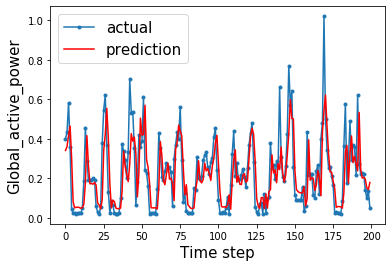

In [56]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

ts =[x for x in range(200)]
plt.plot(ts, y_test[:200], marker='.', label="actual")
plt.plot(ts, prediction[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()